# Przewidywanie oszustw związanych z roszczeniami ubezpieczeniowymi

Projekt ma na celu porównanie popularnych modeli klasyfikacji na podstawie zbioru danych Oracle - "Auto Insurance Claims Fraud".

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Przetwarzanie danych

In [2]:
data = pd.read_csv('fraud_oracle.csv', index_col=0)
data.head()

,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
Month,,,,,,,,,,,,,,,,,,,,,
Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,27,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


Niestety nie został udostępniony opis każdej z kolumn, zatem jedynym wyznacznikiem ich zawartości są nazwy. Na szczęście w większości przypadków są one jednoznaczne i nie pozostawiają wątpliwości.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15420 entries, Dec to Dec
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   WeekOfMonth           15420 non-null  int64 
 1   DayOfWeek             15420 non-null  object
 2   Make                  15420 non-null  object
 3   AccidentArea          15420 non-null  object
 4   DayOfWeekClaimed      15420 non-null  object
 5   MonthClaimed          15420 non-null  object
 6   WeekOfMonthClaimed    15420 non-null  int64 
 7   Sex                   15420 non-null  object
 8   MaritalStatus         15420 non-null  object
 9   Age                   15420 non-null  int64 
 10  Fault                 15420 non-null  object
 11  PolicyType            15420 non-null  object
 12  VehicleCategory       15420 non-null  object
 13  VehiclePrice          15420 non-null  object
 14  FraudFound_P          15420 non-null  int64 
 15  PolicyNumber          15420 non-null  int

### Możemy przyjrzeć się kolumnom zawierających wartości nie będące liczbami i potencjalnie zbędnymi.

Monday       2616
Friday       2445
Tuesday      2300
Thursday     2173
Wednesday    2159
Saturday     1982
Sunday       1745
Name: DayOfWeek, dtype: int64


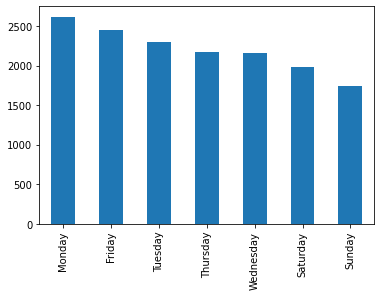

In [4]:
print(data["DayOfWeek"].value_counts())
data["DayOfWeek"].value_counts().plot(kind="bar")
plt.show()

# dummies = pd.get_dummies(data["DayOfWeek"], prefix="DayOfWeek")
# data = pd.concat([data, dummies], axis=1)
# data = data.drop(columns="DayOfWeek")

data["DayOfWeek"] = data["DayOfWeek"].replace({ "Monday": 1, "Tuesday": 2, "Wednesday": 3, "Thursday": 4, "Friday": 5, "Saturday": 6, "Sunday": 7 })

-------------
 Pontiac      3837
Toyota       3121
Honda        2801
Mazda        2354
Chevrolet    1681
Accura        472
Ford          450
VW            283
Dodge         109
Saab          108
Mercury        83
Saturn         58
Nisson         30
BMW            15
Jaguar          6
Porche          5
Mecedes         4
Ferrari         2
Lexus           1
Name: Make, dtype: int64 
-------------



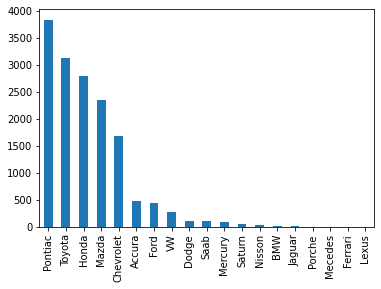

In [5]:
print("-------------\n", data["Make"].value_counts(), "\n-------------\n")
data["Make"].value_counts().plot(kind="bar")
plt.show()

Możemy usunąć najrzadziej występujące marki samochodów ponieważ stanowią bardzo małą część danych, a zmniejszy to ilość nowych kolumn o 6.

In [6]:
data = data[~data["Make"].isin(["Lexus", "Ferrari", "Mercedes", "Porche", "Jaguar", "BMW"])]

dummies = pd.get_dummies(data["Make"], prefix="Make")
data = pd.concat([data, dummies], axis=1)
data = data.drop(columns="Make")

-------------
 Urban    13801
Rural     1590
Name: AccidentArea, dtype: int64 
-------------



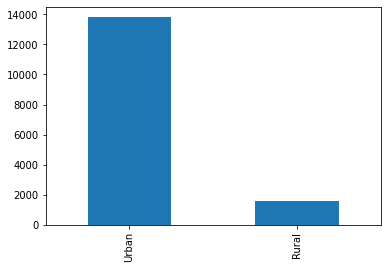

In [7]:
print("-------------\n", data["AccidentArea"].value_counts(), "\n-------------\n")
data["AccidentArea"].value_counts().plot(kind="bar")
plt.show()

dummies = pd.get_dummies(data["AccidentArea"], prefix="AccidentArea")
data = pd.concat([data, dummies], axis=1)
data = data.drop(columns="AccidentArea")

-------------
 Monday       3749
Tuesday      3367
Wednesday    2945
Thursday     2656
Friday       2494
Saturday      127
Sunday         52
0               1
Name: DayOfWeekClaimed, dtype: int64 
-------------



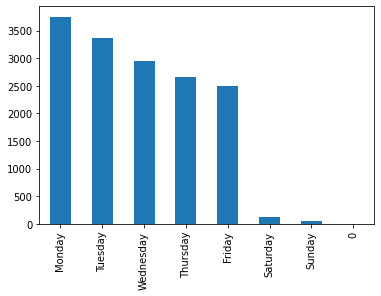

In [8]:
print("-------------\n", data["DayOfWeekClaimed"].value_counts(), "\n-------------\n")
data["DayOfWeekClaimed"].value_counts().plot(kind="bar")
plt.show()

Możemy usunąć wiersz zawierający 0 jako że jest to niepoprawna wartość

In [9]:
data = data[data["DayOfWeekClaimed"] != "0"]

data["DayOfWeekClaimed"] = data["DayOfWeekClaimed"].replace({ "Monday": 1, "Tuesday": 2, "Wednesday": 3, "Thursday": 4, "Friday": 5, "Saturday": 6, "Sunday": 7 })

Jan    1443
May    1410
Mar    1346
Oct    1334
Jun    1290
Feb    1285
Nov    1281
Apr    1270
Sep    1242
Jul    1222
Dec    1144
Aug    1123
Name: MonthClaimed, dtype: int64


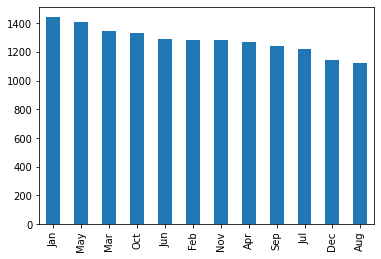

In [10]:
print(data["MonthClaimed"].value_counts())
data["MonthClaimed"].value_counts().plot(kind="bar")
plt.show()

data["MonthClaimed"] = data["MonthClaimed"].replace({ "Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6, "Jul": 7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12 })

Male      12974
Female     2416
Name: Sex, dtype: int64


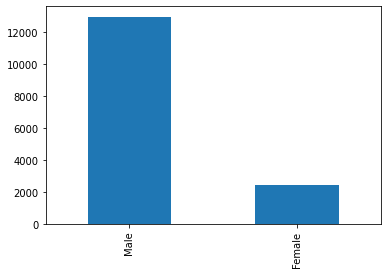

In [11]:
print(data["Sex"].value_counts())
data["Sex"].value_counts().plot(kind="bar")
plt.show()

dummies = pd.get_dummies(data["Sex"], prefix="Sex")
data = pd.concat([data, dummies], axis=1)
data = data.drop(columns="Sex")

Married     10600
Single       4679
Divorced       76
Widow          35
Name: MaritalStatus, dtype: int64


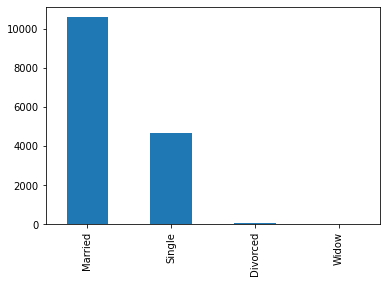

In [12]:
print(data["MaritalStatus"].value_counts())
data["MaritalStatus"].value_counts().plot(kind="bar")
plt.show()

dummies = pd.get_dummies(data["MaritalStatus"], prefix="MaritalStatus")
data = pd.concat([data, dummies], axis=1)
data = data.drop(columns="MaritalStatus")

Policy Holder    11205
Third Party       4185
Name: Fault, dtype: int64


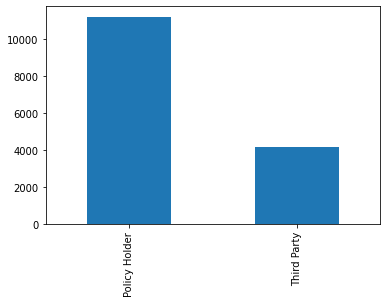

In [13]:
print(data["Fault"].value_counts())
data["Fault"].value_counts().plot(kind="bar")
plt.show()

dummies = pd.get_dummies(data["Fault"], prefix="Fault")
data = pd.concat([data, dummies], axis=1)
data = data.drop(columns="Fault")

Sedan - Collision       5578
Sedan - Liability       4976
Sedan - All Perils      4079
Sport - Collision        348
Utility - All Perils     339
Utility - Collision       26
Sport - All Perils        22
Utility - Liability       21
Sport - Liability          1
Name: PolicyType, dtype: int64


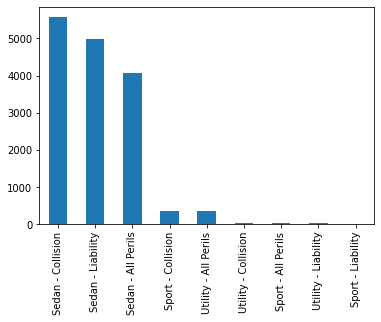

In [14]:
print(data["PolicyType"].value_counts())
data["PolicyType"].value_counts().plot(kind="bar")
plt.show()

Wartość `Sport - Liability` pojawia się tylko raz, więc żeby zredukować liczbę kolumn usuniemy ją

In [15]:
data = data[data["PolicyType"] != "Sport - Liability"]

dummies = pd.get_dummies(data["PolicyType"], prefix="PolicyType")
data = pd.concat([data, dummies], axis=1)
data = data.drop(columns="PolicyType")

Sedan      9657
Sport      5346
Utility     386
Name: VehicleCategory, dtype: int64


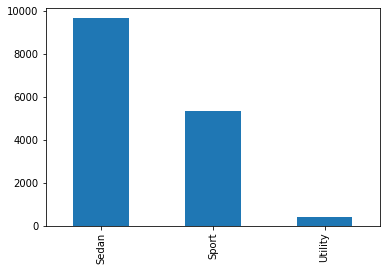

In [16]:
print(data["VehicleCategory"].value_counts())
data["VehicleCategory"].value_counts().plot(kind="bar")
plt.show()

dummies = pd.get_dummies(data["VehicleCategory"], prefix="VehicleCategory")
data = pd.concat([data, dummies], axis=1)
data = data.drop(columns="VehicleCategory")

20000 to 29000     8071
30000 to 39000     3525
more than 69000    2157
less than 20000    1096
40000 to 59000      453
60000 to 69000       87
Name: VehiclePrice, dtype: int64


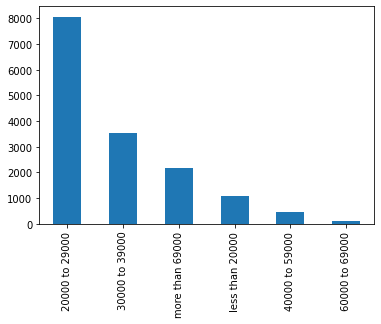

In [17]:
print(data["VehiclePrice"].value_counts())
data["VehiclePrice"].value_counts().plot(kind="bar")
plt.show()

dummies = pd.get_dummies(data["VehiclePrice"], prefix="VehiclePrice")
data = pd.concat([data, dummies], axis=1)
data = data.drop(columns="VehiclePrice")

Możemy usunąć kolumny
- `PolicyNumber` jako wartość losową
- `RepNumber` jako wartość niepotrzebną (o ile może to być ważna wartość, pracownik może pomagać w oszustwie, nie mamy pewności czy numery reprezentantów nie powtarzają się w przypadku zatrudniania nowych osób a brak tego założenia może negatywnie wpływać na wydajność klasyfikatora na prawdziwych danych)

In [18]:
data = data.drop(columns=["PolicyNumber", "RepNumber"])

more than 30    15216
none               55
8 to 15            55
15 to 30           49
1 to 7             14
Name: Days_Policy_Accident, dtype: int64


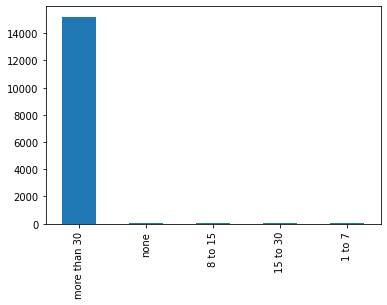

In [19]:
print(data["Days_Policy_Accident"].value_counts())
data["Days_Policy_Accident"].value_counts().plot(kind="bar")
plt.show()

Można zauważyć, że wartość `none` pojawia się 55 razy. Niestety nie udało mi się ustalić co dokładnie oznacza ta kolumna, więc traktuję ją jako missing value.

In [20]:
data = data[data["Days_Policy_Accident"] != "none"]

dummies = pd.get_dummies(data["Days_Policy_Accident"], prefix="Days_Policy_Accident")
data = pd.concat([data, dummies], axis=1)
data = data.drop(columns="Days_Policy_Accident")

more than 30    15275
15 to 30           45
8 to 15            14
Name: Days_Policy_Claim, dtype: int64


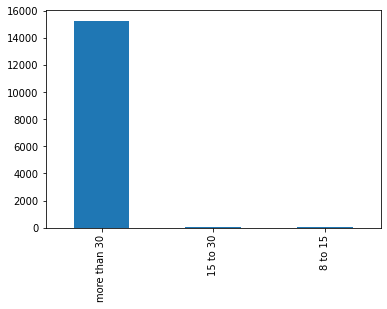

In [21]:
print(data["Days_Policy_Claim"].value_counts())
data["Days_Policy_Claim"].value_counts().plot(kind="bar")
plt.show()

dummies = pd.get_dummies(data["Days_Policy_Claim"], prefix="Days_Policy_Claim")
data = pd.concat([data, dummies], axis=1)
data = data.drop(columns="Days_Policy_Claim")

2 to 4         5458
none           4317
1              3553
more than 4    2006
Name: PastNumberOfClaims, dtype: int64


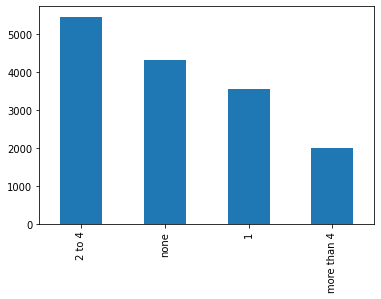

In [22]:
print(data["PastNumberOfClaims"].value_counts())
data["PastNumberOfClaims"].value_counts().plot(kind="bar")
plt.show()

dummies = pd.get_dummies(data["PastNumberOfClaims"], prefix="PastNumberOfClaims")
data = pd.concat([data, dummies], axis=1)
data = data.drop(columns="PastNumberOfClaims")

7 years        5768
more than 7    3961
6 years        3436
5 years        1348
new             372
4 years         227
3 years         151
2 years          71
Name: AgeOfVehicle, dtype: int64


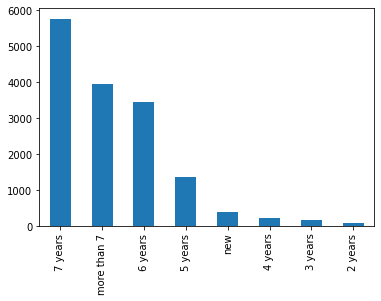

In [23]:
print(data["AgeOfVehicle"].value_counts())
data["AgeOfVehicle"].value_counts().plot(kind="bar")
plt.show()

dummies = pd.get_dummies(data["AgeOfVehicle"], prefix="AgeOfVehicle")
data = pd.concat([data, dummies], axis=1)
data = data.drop(columns="AgeOfVehicle")

31 to 35    5568
36 to 40    4015
41 to 50    2808
51 to 65    1386
26 to 30     608
over 65      508
16 to 17     319
21 to 25     107
18 to 20      15
Name: AgeOfPolicyHolder, dtype: int64


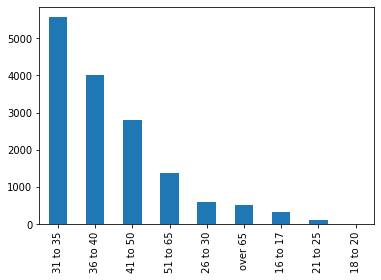

In [24]:
print(data["AgeOfPolicyHolder"].value_counts())
data["AgeOfPolicyHolder"].value_counts().plot(kind="bar")
plt.show()

dummies = pd.get_dummies(data["AgeOfPolicyHolder"], prefix="AgeOfPolicyHolder")
data = pd.concat([data, dummies], axis=1)
data = data.drop(columns="AgeOfPolicyHolder")

No     14909
Yes      425
Name: PoliceReportFiled, dtype: int64


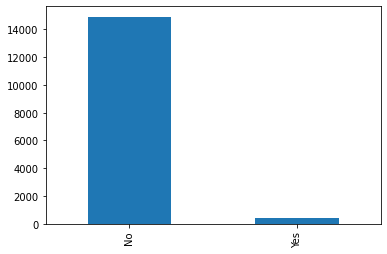

In [25]:
print(data["PoliceReportFiled"].value_counts())
data["PoliceReportFiled"].value_counts().plot(kind="bar")
plt.show()

dummies = pd.get_dummies(data["PoliceReportFiled"], prefix="PoliceReportFiled")
data = pd.concat([data, dummies], axis=1)
data = data.drop(columns="PoliceReportFiled")

No     15248
Yes       86
Name: WitnessPresent, dtype: int64


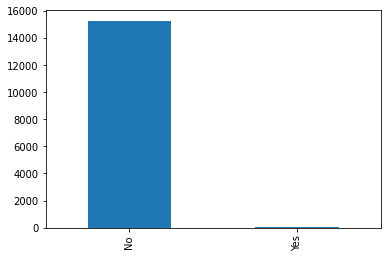

In [26]:
print(data["WitnessPresent"].value_counts())
data["WitnessPresent"].value_counts().plot(kind="bar")
plt.show()

W kolumnie `WitnessPresent` ok. 99.5% wartości to `No`, więc możemy ją usunąć.

In [27]:
data = data.drop(columns="WitnessPresent")

External    15094
Internal      240
Name: AgentType, dtype: int64


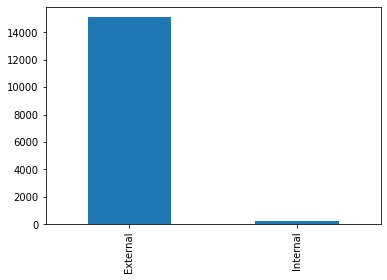

In [28]:
print(data["AgentType"].value_counts())
data["AgentType"].value_counts().plot(kind="bar")
plt.show()

dummies = pd.get_dummies(data["AgentType"], prefix="AgentType")
data = pd.concat([data, dummies], axis=1)
data = data.drop(columns="AgentType")

none           6986
more than 5    3862
1 to 2         2478
3 to 5         2008
Name: NumberOfSuppliments, dtype: int64


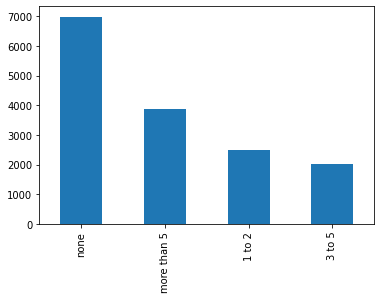

In [29]:
print(data["NumberOfSuppliments"].value_counts())
data["NumberOfSuppliments"].value_counts().plot(kind="bar")
plt.show()

dummies = pd.get_dummies(data["NumberOfSuppliments"], prefix="NumberOfSuppliments")
data = pd.concat([data, dummies], axis=1)
data = data.drop(columns="NumberOfSuppliments")

no change         14247
4 to 8 years        629
2 to 3 years        289
1 year              165
under 6 months        4
Name: AddressChange_Claim, dtype: int64


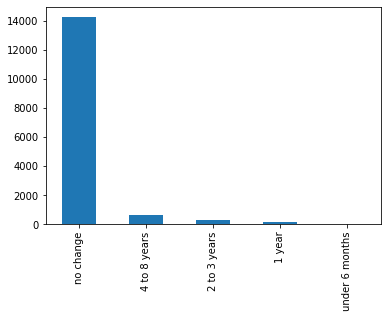

In [30]:
print(data["AddressChange_Claim"].value_counts())
data["AddressChange_Claim"].value_counts().plot(kind="bar")
plt.show()

dummies = pd.get_dummies(data["AddressChange_Claim"], prefix="AddressChange_Claim")
data = pd.concat([data, dummies], axis=1)
data = data.drop(columns="AddressChange_Claim")

1 vehicle      14240
2 vehicles       705
3 to 4           366
5 to 8            21
more than 8        2
Name: NumberOfCars, dtype: int64


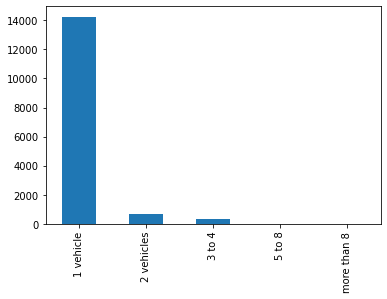

In [31]:
print(data["NumberOfCars"].value_counts())
data["NumberOfCars"].value_counts().plot(kind="bar")
plt.show()

dummies = pd.get_dummies(data["NumberOfCars"], prefix="NumberOfCars")
data = pd.concat([data, dummies], axis=1)
data = data.drop(columns="NumberOfCars")

Kolumnę `Year` możemy usunąć, zakładając że model ma działać na aktualnych danych.

In [32]:
data = data.drop(columns="Year")

Collision     5923
Liability     4992
All Perils    4419
Name: BasePolicy, dtype: int64


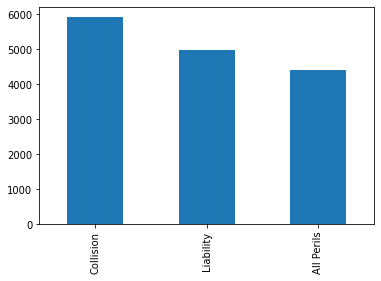

In [33]:
print(data["BasePolicy"].value_counts())
data["BasePolicy"].value_counts().plot(kind="bar")
plt.show()

dummies = pd.get_dummies(data["BasePolicy"], prefix="BasePolicy")
data = pd.concat([data, dummies], axis=1)
data = data.drop(columns="BasePolicy")

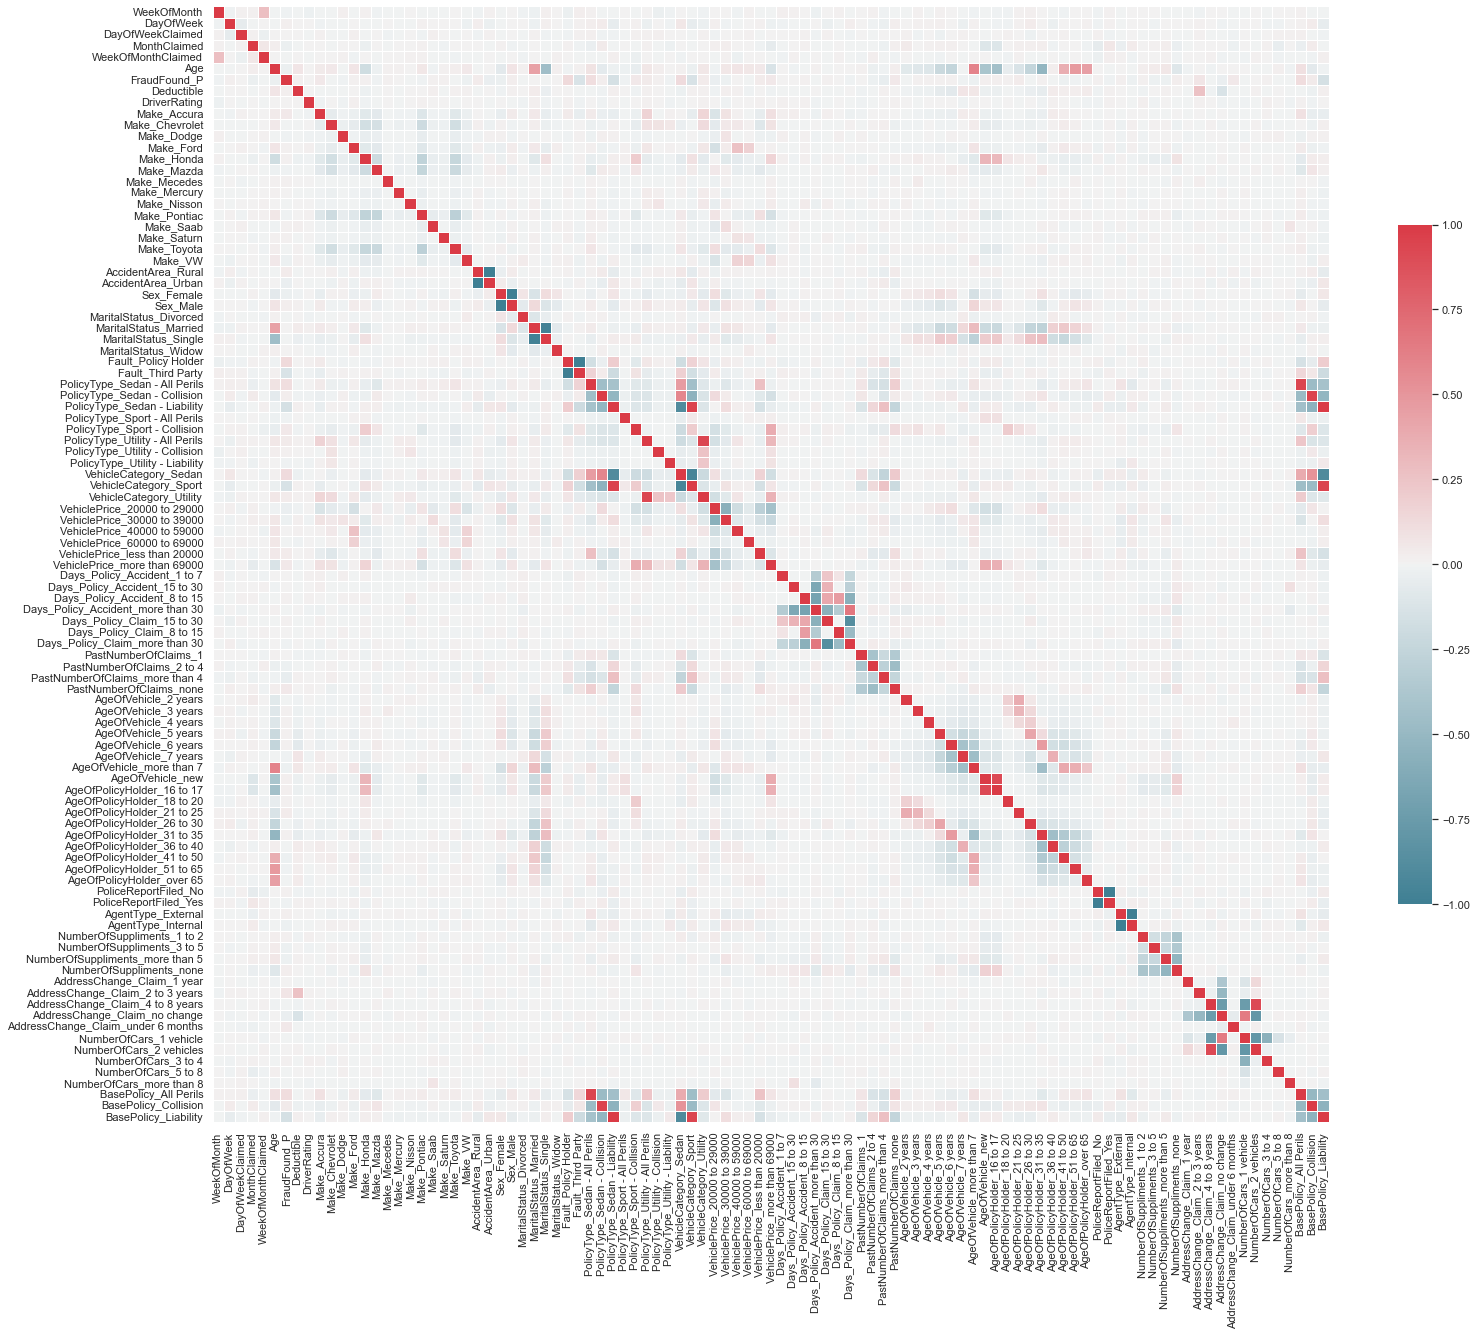

In [34]:
import seaborn as sns

sns.set(style="darkgrid")

corr = data.corr()
f, ax = plt.subplots(figsize=(25, 25))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, cmap=cmap, vmin=-1, vmax=1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.show()

Poza oczywistymi korelacjami pomiędzy kolumnami boolowskimi (np. płeć, czy teren zdarzenia), czy typami polis możemy zauważyć kilka bardziej interesujących przypadków:
- związek pomiędzy stanem cywilnym, a wiekiem posiadacza polisy
- związek pomiędzy ubezpieczeniem OC, a posiadaniem samochodu sportowego
- związek pomiędzy ubezpieczeniem od wszystkich niebezpieczeństw, a posiadaniem samochodu użytkowego
- związek pomiędzy wiekiem samochodu, a wiekiem posiadacza polisy (szczególnie wyraźna korelacja pomiędzy nowymi samochodami a wiekiem pomiędzy 16 i 17)
- ciekawe wydają się też związek pomiędzy posiadaniem 2 samochodów a zmianą adresu w ciągu 4-8 lat i pomiędzy posiadaniem jednego samochodu a brakiem zmiany adresu w ciągu 6 miesięcy

## Trenowanie

Możemy podzielić dane na treningowe i testowe

In [97]:
from sklearn.model_selection import train_test_split

X = data.loc[:, data.columns != "FraudFound_P"]
y = data["FraudFound_P"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.85, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2300, 98) (2300,)
(13034, 98) (13034,)


In [98]:
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

kfold = model_selection.KFold(n_splits=5, random_state=None)

import warnings
warnings.filterwarnings("ignore")

### Logistic regression

In [99]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', LogisticRegression())])

param_grid = {
            'preprocessing': [StandardScaler(), None],
            'classifier__C': [1e-4, 0.001, 0.01, 0.1, 1, 10],
}

logistic_regression = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True, scoring='recall')

logistic_regression.fit(X_train, y_train)
logistic_regression.best_params_

{'classifier__C': 1, 'preprocessing': StandardScaler()}

### SVM z jądrem `linear`

In [100]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC(kernel='linear'))])

param_grid = {
            'preprocessing': [StandardScaler(), None],
            'classifier__C': [0.0001, 0.001, 0.001, 0.01, 0.1, 1],
}

svm_linear = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True, scoring='recall')

svm_linear.fit(X_train, y_train)
svm_linear.best_params_

{'classifier__C': 0.0001, 'preprocessing': StandardScaler()}

### SVM z jądrem `poly`

In [101]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC(kernel='poly'))])

param_grid = {
            'preprocessing': [StandardScaler(), None],
            'classifier__C': [0.0001, 0.001, 0.001, 0.01, 0.1, 1],
            'classifier__coef0': [0.0001, 0.001, 0.001, 0.01, 0.1, 1],
            'classifier__degree': [1, 2, 3, 4],
}

svm_poly = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True, scoring='recall')

svm_poly.fit(X_train, y_train)
svm_poly.best_params_

{'classifier__C': 1,
 'classifier__coef0': 1,
 'classifier__degree': 4,
 'preprocessing': StandardScaler()}

### SVM z jądrem `rbf`

In [102]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC(kernel='rbf'))])

param_grid = {
            'preprocessing': [StandardScaler(), None],
            'classifier__C': [0.0001, 0.001, 0.001, 0.01, 0.1, 1],
            'classifier__gamma': [0.0001, 0.001, 0.001, 0.01, 0.1, 1],
}

svm_rbf = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True, scoring='recall')

svm_rbf.fit(X_train, y_train)
svm_rbf.best_params_

{'classifier__C': 1,
 'classifier__gamma': 0.01,
 'preprocessing': StandardScaler()}

### DecisionTreeClassifier

In [103]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', DecisionTreeClassifier())])

param_grid = {
            'preprocessing': [StandardScaler(), None],
            'classifier__max_depth': [2, 5, 10, 15, 20],
            'classifier__max_leaf_nodes': [10, 20, 30, 40, 50, 100],
            'classifier__criterion': ['gini', 'entropy'],
}

decision_tree = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True, scoring='recall')

decision_tree.fit(X_train, y_train)
decision_tree.best_params_

{'classifier__criterion': 'gini',
 'classifier__max_depth': 15,
 'classifier__max_leaf_nodes': 100,
 'preprocessing': None}

### RandomForestClassifier

In [104]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', RandomForestClassifier())])

param_grid = {
            'preprocessing': [StandardScaler(), None],
            'classifier__n_estimators': [2, 4, 8, 16, 32, 64],
            'classifier__max_leaf_nodes': [5, 10, 20, 30, 40, 50],
}

random_forest = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True, scoring='recall')

random_forest.fit(X_train, y_train)
random_forest.best_params_

{'classifier__max_leaf_nodes': 50,
 'classifier__n_estimators': 2,
 'preprocessing': None}

### BaggingClassifier

In [105]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', BaggingClassifier())])

param_grid = {
            'preprocessing': [StandardScaler(), None],
            'classifier__n_estimators': [4, 8, 16, 32],
            'classifier__max_samples': [0.01, 0.05, 0.1, 0.2, 0.4, 0.8],
}

bagging = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True, scoring='recall')

bagging.fit(X_train, y_train)
bagging.best_params_

{'classifier__max_samples': 0.8,
 'classifier__n_estimators': 8,
 'preprocessing': StandardScaler()}

### AdaBoostClassifier

In [106]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', AdaBoostClassifier())])

param_grid = {
            'preprocessing': [StandardScaler(), None],
            'classifier__n_estimators': [2, 4, 8, 16, 32],
            'classifier__learning_rate': [0.00001, 0.0001, 0.001, 0.01, 0.1],
}

ada_boost = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True, scoring='recall')

ada_boost.fit(X_train, y_train)
ada_boost.best_params_

{'classifier__learning_rate': 1e-05,
 'classifier__n_estimators': 2,
 'preprocessing': StandardScaler()}

### GradientBoostingClassifier

In [107]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', GradientBoostingClassifier())])

param_grid = {
            'preprocessing': [StandardScaler(), None],
            'classifier__n_estimators': [2, 4, 8, 16, 32],
            'classifier__learning_rate': [0.00001, 0.0001, 0.001, 0.01, 0.1],
}

gradient_boosting = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True, scoring='recall')

gradient_boosting.fit(X_train, y_train)
gradient_boosting.best_params_

{'classifier__learning_rate': 0.1,
 'classifier__n_estimators': 32,
 'preprocessing': StandardScaler()}

### KNeighborsClassifier

In [108]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', KNeighborsClassifier())])

param_grid = {
            'preprocessing': [StandardScaler(), None],
            'classifier__n_neighbors': [2, 4, 8],
            'classifier__p': [1, 2, 4],
}

k_neighbors = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True, scoring='recall')

k_neighbors.fit(X_train, y_train)
k_neighbors.best_params_

{'classifier__n_neighbors': 4,
 'classifier__p': 1,
 'preprocessing': StandardScaler()}

### MLPClassifier

In [109]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', MLPClassifier())])

param_grid = {
            'preprocessing': [StandardScaler(), None],
            'classifier__hidden_layer_sizes': [(16, 8)],
            'classifier__learning_rate_init': [0.001, 0.01, 0.1],
            'classifier__max_iter': [100, 500, 1000],
            'classifier__batch_size': [10, 20, 30],
}

mlp = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True, scoring='recall')

mlp.fit(X_train, y_train)
mlp.best_params_

{'classifier__batch_size': 20,
 'classifier__hidden_layer_sizes': (16, 8),
 'classifier__learning_rate_init': 0.01,
 'classifier__max_iter': 1000,
 'preprocessing': StandardScaler()}

### Keras

In [167]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import History

history = History()
keras_model = Sequential()
keras_model.add(Dense(200,activation="sigmoid", input_shape=(X_train.shape[1],)))
keras_model.add(Dense(100,activation="sigmoid"))
keras_model.add(Dense(50,activation="sigmoid"))
keras_model.add(Dense(1,activation="sigmoid"))
keras_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 200)               19800     
                                                                 
 dense_33 (Dense)            (None, 100)               20100     
                                                                 
 dense_34 (Dense)            (None, 50)                5050      
                                                                 
 dense_35 (Dense)            (None, 1)                 51        
                                                                 
Total params: 45,001
Trainable params: 45,001
Non-trainable params: 0
_________________________________________________________________


In [168]:
keras_model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=[tf.keras.metrics.Recall()])

X_train_keras, X_val, y_train_keras, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)


In [169]:
history = keras_model.fit(X_train_keras, y_train_keras, validation_data=(X_val, y_val), batch_size=32, epochs=25)

Epoch 1/25
65/65 [==============================] - 2s 12ms/step - loss: 0.3202 - recall_6: 0.0769 - val_loss: 0.2782 - val_recall_6: 0.0000e+00
Epoch 2/25
65/65 [==============================] - 1s 9ms/step - loss: 0.2175 - recall_6: 0.0000e+00 - val_loss: 0.2788 - val_recall_6: 0.0000e+00
Epoch 3/25
65/65 [==============================] - 1s 9ms/step - loss: 0.2177 - recall_6: 0.0000e+00 - val_loss: 0.2800 - val_recall_6: 0.0000e+00
Epoch 4/25
65/65 [==============================] - 1s 9ms/step - loss: 0.2175 - recall_6: 0.0000e+00 - val_loss: 0.2787 - val_recall_6: 0.0000e+00
Epoch 5/25
65/65 [==============================] - 1s 8ms/step - loss: 0.2176 - recall_6: 0.0000e+00 - val_loss: 0.2788 - val_recall_6: 0.0000e+00
Epoch 6/25
65/65 [==============================] - 1s 8ms/step - loss: 0.2176 - recall_6: 0.0000e+00 - val_loss: 0.2778 - val_recall_6: 0.0000e+00
Epoch 7/25
65/65 [==============================] - 1s 8ms/step - loss: 0.2173 - recall_6: 0.0000e+00 - val_loss: 0

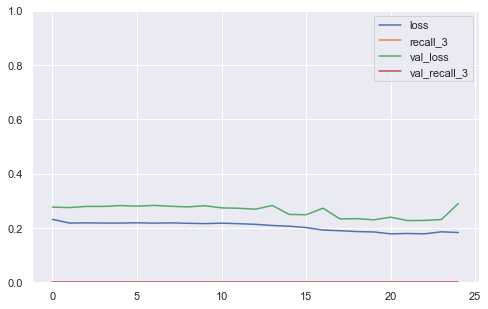

In [147]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [174]:
test_eval = keras_model.evaluate(X_test,y_test)
test_eval

408/408 [==============================] - 2s 5ms/step - loss: 0.2164 - recall_6: 0.0000e+00


[0.21638251841068268, 0.0]

## Porównanie modeli

In [180]:
from sklearn import metrics

models = []
models.append(('Logistic regression', logistic_regression.best_estimator_))
models.append(('SVM linear', svm_linear.best_estimator_))
models.append(('SVM poly', svm_poly.best_estimator_))
models.append(('SVM rbf', svm_rbf.best_estimator_))
models.append(('DecisionTreeClassifier', decision_tree.best_estimator_))
models.append(('RandomForestClassifier', random_forest.best_estimator_))
models.append(('BaggingClassifier', bagging.best_estimator_))
models.append(('AdaBoostClassifier', ada_boost.best_estimator_))
models.append(('GradientBoostingClassifier', gradient_boosting.best_estimator_))
models.append(('KNeighborsClassifier', k_neighbors.best_estimator_))
models.append(('MLPClassifier', mlp.best_estimator_))
models.append(('Keras', keras_model))

precision = []
recall = []
f1 = []
accuracy = []
roc_auc = []
for name, model in models:
    pred = model.predict(X_test)
    if name == 'Keras':
        pred = [round(x[0]) for x in keras_model.predict(X_test)]
    precision.append(metrics.precision_score(y_test, pred))
    recall.append(metrics.recall_score(y_test, pred))
    f1.append( metrics.f1_score(y_test, pred))
    accuracy.append(metrics.accuracy_score(y_test, pred)) 
    roc_auc.append(metrics.roc_auc_score(y_test, pred))

In [181]:
d = {
    'precision': precision, 
    'recall': recall, 
    'f1': f1,
    'accuracy' : accuracy,
    'roc_auc' : roc_auc
}
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Model', value=['Logistic regression', 'SVM linear', 'SVM poly', 'SVM rbf', 'DecisionTreeClassifier', 'RandomForestClassifier',
                                        'BaggingClassifier', 'AdaBoostClassifier','GradientBoostingClassifier', 'KNeighborsClassifier', 'MLPClassifier', 'Keras'])
df

,Model,precision,recall,f1,accuracy,roc_auc
0,Logistic regression,0.106383,0.006427,0.012121,0.937471,0.501500
1,SVM linear,0.000000,0.000000,0.000000,0.940310,0.500000
2,SVM poly,0.229249,0.074550,0.112512,0.929799,0.529320
3,SVM rbf,0.250000,0.003856,0.007595,0.939850,0.501561
4,DecisionTreeClassifier,0.172589,0.131105,0.149014,0.910618,0.545603
5,RandomForestClassifier,0.152104,0.060411,0.086477,0.923815,0.519517
6,BaggingClassifier,0.227273,0.044987,0.075107,0.933865,0.517639
7,AdaBoostClassifier,0.000000,0.000000,0.000000,0.940310,0.500000
8,GradientBoostingClassifier,0.500000,0.002571,0.005115,0.940310,0.501204
9,KNeighborsClassifier,0.214286,0.015424,0.028777,0.937855,0.505917
